### Download Necessary Libraries

In [1]:
!pip install kaggle
!pip install scipy
!pip install scikit-learn
!pip install seaborn
!pip install pandas
!pip install Pyarrow


[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


### Import Necessary Libraries

In [2]:
import kaggle
import pandas as pd
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
import seaborn as sns

# used to build the models with
import torch
from torch import nn
from torch.nn import LSTM, Linear
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

# used for importing the train_test_split module to split the data
from sklearn.model_selection import train_test_split
# used to scale the data for Principal Component Analysis
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
# used for importing Principal Component Analysis
from sklearn.decomposition import PCA

### Connect to Kaggle and Import Dataset

In [3]:
kaggle.api.authenticate()

In [4]:
kaggle.api.dataset_download_files('arashnic/fitbit', path='/python_code_src/coding', unzip=True)

### Load datasets

In [5]:
activity = pd.read_csv('/python_code_src/coding/Fitabase Data 4.12.16-5.12.16/dailyActivity_merged.csv')
sleep = pd.read_csv('/python_code_src/coding/Fitabase Data 4.12.16-5.12.16/sleepDay_merged.csv')
weight = pd.read_csv('/python_code_src/coding/Fitabase Data 4.12.16-5.12.16/weightLogInfo_merged.csv')

### Rename and change data types for 'activity' dataset

In [6]:
activity.rename(columns={'ActivityDate': 'Date_Merge'}, inplace=True)
activity['Date_Merge'] = pd.to_datetime(activity['Date_Merge'], format = '%m/%d/%Y')
activity['Id'] = activity['Id'].astype('int64')
activity.drop(['TrackerDistance', 'LoggedActivitiesDistance'], axis=1, inplace=True)

### Rename and change data types for 'sleep' dataset

In [7]:
sleep.rename(columns={'SleepDay': 'Date_Merge'}, inplace=True)
sleep['Date_Merge'] = pd.to_datetime(sleep['Date_Merge'], format='%m/%d/%Y %I:%M:%S %p').dt.strftime('%m/%d/%Y')
sleep['Date_Merge'] = sleep['Date_Merge'].astype('datetime64[ns]')
sleep['Id'] = sleep['Id'].astype('int64')
sleep = sleep[['Id', 'Date_Merge', 'TotalSleepRecords','TotalMinutesAsleep','TotalTimeInBed']]

### Rename and change data types for 'weight' dataset

In [8]:
weight.rename(columns={'Date': 'Date_Merge'}, inplace=True)
weight['Date_Merge'] = pd.to_datetime(weight['Date_Merge'], format='%m/%d/%Y %I:%M:%S %p').dt.strftime('%m/%d/%Y')
weight['Date_Merge'] = weight['Date_Merge'].astype('datetime64[ns]')
weight['Id'] = weight['Id'].astype('int64')
weight = weight[['Id', 'Date_Merge', 'WeightKg', 'WeightPounds', 'Fat', 'BMI']]

In [9]:
activity.head()

,Id,Date_Merge,TotalSteps,TotalDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories
0,1503960366,2016-04-12,13162,8.50,1.88,0.55,6.06,0.0,25,13,328,728,1985
1,1503960366,2016-04-13,10735,6.97,1.57,0.69,4.71,0.0,21,19,217,776,1797
2,1503960366,2016-04-14,10460,6.74,2.44,0.40,3.91,0.0,30,11,181,1218,1776
3,1503960366,2016-04-15,9762,6.28,2.14,1.26,2.83,0.0,29,34,209,726,1745
4,1503960366,2016-04-16,12669,8.16,2.71,0.41,5.04,0.0,36,10,221,773,1863


In [10]:
activity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 940 entries, 0 to 939
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Id                        940 non-null    int64         
 1   Date_Merge                940 non-null    datetime64[ns]
 2   TotalSteps                940 non-null    int64         
 3   TotalDistance             940 non-null    float64       
 4   VeryActiveDistance        940 non-null    float64       
 5   ModeratelyActiveDistance  940 non-null    float64       
 6   LightActiveDistance       940 non-null    float64       
 7   SedentaryActiveDistance   940 non-null    float64       
 8   VeryActiveMinutes         940 non-null    int64         
 9   FairlyActiveMinutes       940 non-null    int64         
 10  LightlyActiveMinutes      940 non-null    int64         
 11  SedentaryMinutes          940 non-null    int64         
 12  Calories              

In [11]:
sleep.head()

,Id,Date_Merge,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed
0,1503960366,2016-04-12,1,327,346
1,1503960366,2016-04-13,2,384,407
2,1503960366,2016-04-15,1,412,442
3,1503960366,2016-04-16,2,340,367
4,1503960366,2016-04-17,1,700,712


In [12]:
sleep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413 entries, 0 to 412
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Id                  413 non-null    int64         
 1   Date_Merge          413 non-null    datetime64[ns]
 2   TotalSleepRecords   413 non-null    int64         
 3   TotalMinutesAsleep  413 non-null    int64         
 4   TotalTimeInBed      413 non-null    int64         
dtypes: datetime64[ns](1), int64(4)
memory usage: 16.3 KB


In [13]:
weight.head()

,Id,Date_Merge,WeightKg,WeightPounds,Fat,BMI
0,1503960366,2016-05-02,52.599998,115.963147,22.0,22.650000
1,1503960366,2016-05-03,52.599998,115.963147,NaN,22.650000
2,1927972279,2016-04-13,133.500000,294.317120,NaN,47.540001
3,2873212765,2016-04-21,56.700001,125.002104,NaN,21.450001
4,2873212765,2016-05-12,57.299999,126.324875,NaN,21.690001


In [14]:
weight.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Id            67 non-null     int64         
 1   Date_Merge    67 non-null     datetime64[ns]
 2   WeightKg      67 non-null     float64       
 3   WeightPounds  67 non-null     float64       
 4   Fat           2 non-null      float64       
 5   BMI           67 non-null     float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 3.3 KB


### Merge datasets

In [15]:
merged_df = pd.merge(activity, sleep, on=['Id','Date_Merge'], how='outer')
merged_df = pd.merge(merged_df, weight, on=['Id','Date_Merge'], how='outer')

### Check the data types of 'Date_Merge' columns in all three datasets and ensure they are strings before converting them to datetime objects

In [16]:
merged_df['Date_Merge'].apply(type).unique()

array([<class 'pandas._libs.tslibs.timestamps.Timestamp'>], dtype=object)

### Interpolate missing values

In [17]:
merged_df = merged_df.fillna(0)

In [18]:
for col in merged_df.columns:
    if merged_df[col].isna().any():
        merged_df[col] = merged_df[col].interpolate(method='cubic')

### Change data types for all columns except 'Id' and 'Date_Merge'

In [19]:
merged_df = merged_df.astype({col: 'float64' for col in merged_df.columns if col not in ['Id', 'Date_Merge']})

### Set Date_Merge and Id as the Index, sort the data to the dataset and rename the index

In [20]:
merged_df.set_index(['Id', 'Date_Merge'], inplace=True)

In [21]:
merged_df.sort_index(inplace=True)

In [22]:
merged_df.index.name = 'Id_DateMerge_Index'

In [23]:
merged_df.head()

TotalSteps  TotalDistance  VeryActiveDistance  \
Id         Date_Merge                                                  
1503960366 2016-04-12     13162.0           8.50                1.88   
           2016-04-13     10735.0           6.97                1.57   
           2016-04-14     10460.0           6.74                2.44   
           2016-04-15      9762.0           6.28                2.14   
           2016-04-16     12669.0           8.16                2.71   

                       ModeratelyActiveDistance  LightActiveDistance  \
Id         Date_Merge                                                  
1503960366 2016-04-12                      0.55                 6.06   
           2016-04-13                      0.69                 4.71   
           2016-04-14                      0.40                 3.91   
           2016-04-15                      1.26                 2.83   
           2016-04-16                      0.41                 5.04   

                       SedentaryActiveDistance  VeryActiveMinutes  \
Id         Date_Merge                                               
1503960366 2016-04-12                      0.0               25.0   
           2016-04-13                      0.0               21.0   
           2016-04-14                      0.0               30.0   
           2016-04-15                      0.0               29.0   
           2016-04-16                      0.0               36.0   

                       FairlyActiveMinutes  LightlyActiveMinutes  \
Id         Date_Merge                                              
1503960366 2016-04-12                 13.0                 328.0   
           2016-04-13                 19.0                 217.0   
           2016-04-14                 11.0                 181.0   
           2016-04-15                 34.0                 209.0   
           2016-04-16                 10.0                 221.0   

                       SedentaryMinutes  Calories  TotalSleepRecords  \
Id         Date_Merge                                                  
1503960366 2016-04-12             728.0    1985.0                1.0   
           2016-04-13             776.0    1797.0                2.0   
           2016-04-14            1218.0    1776.0                0.0   
           2016-04-15             726.0    1745.0                1.0   
           2016-04-16             773.0    1863.0                2.0   

                       TotalMinutesAsleep  TotalTimeInBed  WeightKg  \
Id         Date_Merge                                                 
1503960366 2016-04-12               327.0           346.0       0.0   
           2016-04-13               384.0           407.0       0.0   
           2016-04-14                 0.0             0.0       0.0   
           2016-04-15               412.0           442.0       0.0   
           2016-04-16               340.0           367.0       0.0   

                       WeightPounds  Fat  BMI  
Id         Date_Merge                          
1503960366 2016-04-12           0.0  0.0  0.0  
           2016-04-13           0.0  0.0  0.0  
           2016-04-14           0.0  0.0  0.0  
           2016-04-15           0.0  0.0  0.0  
           2016-04-16           0.0  0.0  0.0

### Exploratory Data Analysis

#### Merged dataframe info

In [24]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 943 entries, (1503960366, Timestamp('2016-04-12 00:00:00')) to (8877689391, Timestamp('2016-05-12 00:00:00'))
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   TotalSteps                943 non-null    float64
 1   TotalDistance             943 non-null    float64
 2   VeryActiveDistance        943 non-null    float64
 3   ModeratelyActiveDistance  943 non-null    float64
 4   LightActiveDistance       943 non-null    float64
 5   SedentaryActiveDistance   943 non-null    float64
 6   VeryActiveMinutes         943 non-null    float64
 7   FairlyActiveMinutes       943 non-null    float64
 8   LightlyActiveMinutes      943 non-null    float64
 9   SedentaryMinutes          943 non-null    float64
 10  Calories                  943 non-null    float64
 11  TotalSleepRecords         943 non-null    float64
 12  TotalMinutesAsleep        943 no

#### Merged Dataframe Statistics

In [25]:
merged_df.describe()

,TotalSteps,TotalDistance,VeryActiveDistance,ModeratelyActiveDistance,LightActiveDistance,SedentaryActiveDistance,VeryActiveMinutes,FairlyActiveMinutes,LightlyActiveMinutes,SedentaryMinutes,Calories,TotalSleepRecords,TotalMinutesAsleep,TotalTimeInBed,WeightKg,WeightPounds,Fat,BMI
count,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000
mean,7652.188759,5.502853,1.504316,0.570880,3.349258,0.001601,21.239661,13.628844,193.025451,990.353128,2307.507953,0.489926,183.711559,200.867444,5.118134,11.283553,0.049841,1.789406
std,5086.532832,3.926509,2.657626,0.884775,2.046505,0.007335,32.946264,20.000746,109.308468,301.262473,720.815522,0.600472,222.446772,242.690161,18.879605,41.622405,1.083880,6.524423
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3795.000000,2.620000,0.000000,0.000000,1.950000,0.000000,0.000000,0.000000,127.000000,729.000000,1829.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7439.000000,5.260000,0.220000,0.240000,3.380000,0.000000,4.000000,7.000000,199.000000,1057.000000,2140.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,10734.000000,7.720000,2.065000,0.805000,4.790000,0.000000,32.000000,19.000000,264.000000,1229.000000,2796.500000,1.000000,417.500000,450.500000,0.000000,0.000000,0.000000,0.000000
max,36019.000000,28.030001,21.920000,6.480000,10.710000,0.110000,210.000000,143.000000,518.000000,1440.000000,4900.000000,3.000000,796.000000,961.000000,133.500000,294.317120,25.000000,47.540001


#### Determine the merged dataframe shape

In [26]:
print("Shape of merged dataframe: ", merged_df.shape)

Shape of merged dataframe:  (943, 18)


#### Get average total steps per Id, for the first five Ids

In [27]:
print(merged_df[['TotalSteps']].groupby('Id').mean().head()) 

              TotalSteps
Id                      
1503960366  12116.741935
1624580081   5743.903226
1644430081   7282.966667
1844505072   2580.064516
1927972279    916.129032


#### Build dataframes to chart the data

In [28]:
df_heatmap = merged_df.copy()

In [29]:
df_scattermap = merged_df.copy()
df_scattermap = df_scattermap[['TotalMinutesAsleep', 'Calories']]

In [30]:
df_scattermap.head()

TotalMinutesAsleep  Calories
Id         Date_Merge                              
1503960366 2016-04-12               327.0    1985.0
           2016-04-13               384.0    1797.0
           2016-04-14                 0.0    1776.0
           2016-04-15               412.0    1745.0
           2016-04-16               340.0    1863.0

### Create a heatmap for correlation

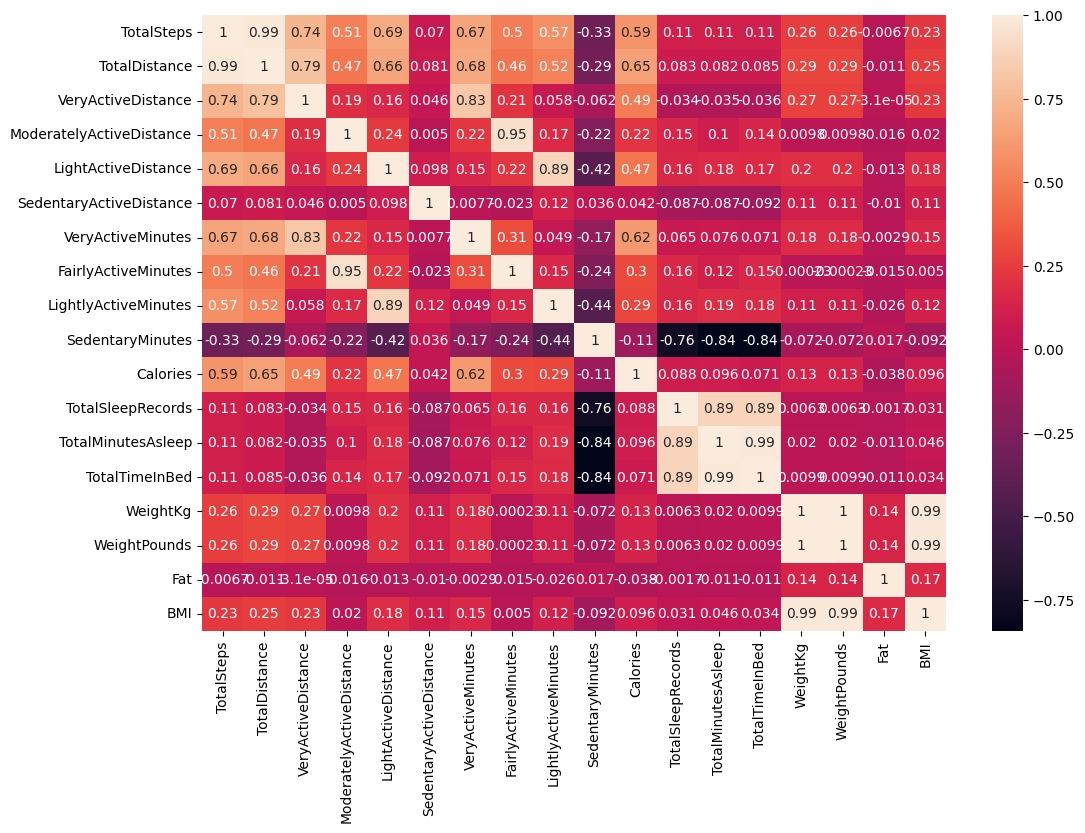

In [31]:
plt.figure(figsize=(12,8))
sns.heatmap(merged_df.corr(), annot=True)
plt.show()

### Scattermap with directional lines to correlation between 'TotalMinutesAsleep' and 'Calories'

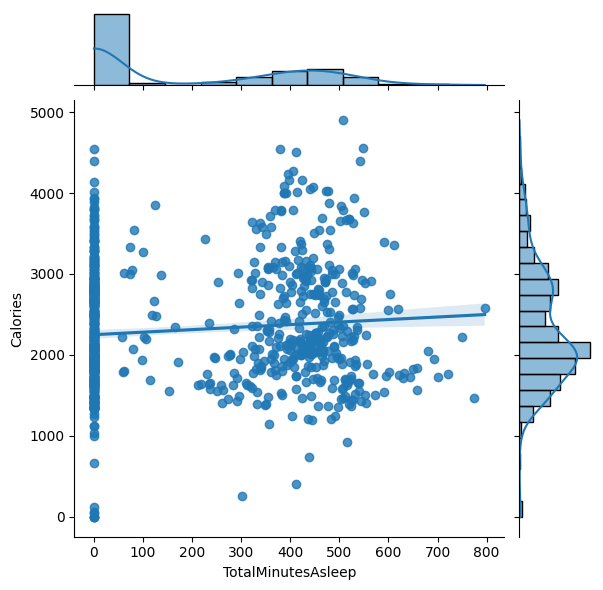

In [32]:
g = sns.jointplot(x="TotalMinutesAsleep", y="Calories", data=df_scattermap, kind="reg")
plt.show()

### Add Principal Component Analysis to determine and confirm the Features that need to be used for the models that will be built later

#### First build datasets for each model
##### Model type 1: 
predict how many calories will be burned in the next 7 days for each 'Id', based on the features in the dataframe that are closely related 
to calories

##### Model type 2: 
predict how many steps per day in the next 7 days for each 'Id', based on the features in the dataframe that are closely related 
to steps
##### Model type 3: 
predict how many 'Calories', 'TotalDistance', 'TotalMinutesAsleep', 'WeightPounds', 'BMI', 'VeryActiveDistance', 'ModeratelyActiveDistance', 
'LightActiveDistance', 'SedentaryActiveDistance', 'VeryActiveMinutes','FairlyActiveMinutes','LightlyActiveMinutes','SedentaryMinutes' per day in 
the next 7 days for 'Id' ['1927972279'], to get to ten thousand steps per day

In [33]:
df_calories_burned = merged_df.copy()
df_calories_burned_target = df_calories_burned[['Calories']]
df_calories_burned_no_target = df_calories_burned.drop(['Calories'], axis = 1)

df_total_steps = merged_df.copy()
df_total_steps_target = df_total_steps[['TotalSteps']]
df_total_steps_no_target = df_total_steps.drop(['TotalSteps'], axis = 1)

# get the dataset only for Id = 192797227
df_multivariate_per_Id = merged_df.loc[1927972279].copy()
df_multivariate_per_Id_features = df_multivariate_per_Id
# Define target columns
targets = ['Calories', 'TotalDistance', 'TotalMinutesAsleep', 
           'WeightPounds', 'BMI', 'VeryActiveDistance', 
           'ModeratelyActiveDistance', 'LightActiveDistance', 
           'SedentaryActiveDistance', 'VeryActiveMinutes',
           'FairlyActiveMinutes','LightlyActiveMinutes', 
           'SedentaryMinutes']

# Create df_multivariate_per_Id_targets dataframe
df_multivariate_per_Id_targets = df_multivariate_per_Id[targets]


In [34]:
#Set both data sets as X and y for the models, will be used with all models
X_calories_burned = df_calories_burned_no_target.copy()
y_calories_burned = df_calories_burned_target.copy()

X_total_steps = df_total_steps_no_target.copy()
y_total_steps = df_total_steps_target.copy()

X_multivariate_per_Id_features = df_multivariate_per_Id_features
y_multivariate_per_Id_targets = df_multivariate_per_Id_targets


# used the first ID in the dataset, will be used for PCA
X_calories_burned_user = df_calories_burned_no_target.loc[1503960366].copy()
y_calories_burned_user = df_calories_burned_target.loc[1503960366].copy()

X_total_steps_user = df_total_steps_no_target.loc[1503960366].copy()
y_total_steps_user = df_total_steps_target.loc[1503960366].copy()

#### Scale the data for each dataframe that has no target

In [35]:
calories_burned_features_scaler = MinMaxScaler(feature_range = (0,1))

X_calories_burned_normalized_0_to_1 = calories_burned_features_scaler.fit_transform(X_calories_burned)

In [36]:
calories_burned_targets_scaler = MinMaxScaler(feature_range = (0,1))

# Fit the scaler to the targets and transform them
y_calories_burned_normalized_0_to_1 = calories_burned_targets_scaler.fit_transform(y_calories_burned)

In [37]:
calories_user_scaler = MinMaxScaler(feature_range = (0,1))

X_calories_burned_user_normalized_0_to_1 = calories_user_scaler.fit_transform(X_calories_burned_user)

In [38]:
total_steps_features_scaler = MinMaxScaler(feature_range = (0,1))

X_total_steps_normalized_0_to_1 = total_steps_features_scaler.fit_transform(X_total_steps)

In [39]:
total_steps_target_scaler = MinMaxScaler(feature_range = (0,1))

# Fit the scaler to the targets and transform them
y_total_steps_normalized_0_to_1 = total_steps_target_scaler.fit_transform(y_total_steps)

In [40]:
total_steps_user_scaler = MinMaxScaler(feature_range = (0,1))

X_total_steps_user_normalized_0_to_1 = total_steps_user_scaler.fit_transform(X_total_steps_user)

In [41]:
multivariate_features_scaler = MinMaxScaler(feature_range = (0,1))

X_multivariate_per_Id_features_normalized_0_to_1 = multivariate_features_scaler.fit_transform(X_multivariate_per_Id_features)

In [42]:
multivariate_target_scaler = MinMaxScaler(feature_range = (0,1))

# Fit the scaler to the targets and transform them
y_multivariate_per_Id_normalized_0_to_1 = multivariate_target_scaler.fit_transform(y_multivariate_per_Id_targets)

#### Run the Principal Component Analysis for predicting calories burned

In [43]:
pca_calories_burned = PCA()
pca_calories_burned.fit(X_calories_burned_user_normalized_0_to_1,y_calories_burned_user)

pca_total_steps = PCA()
pca_total_steps.fit(X_total_steps_user_normalized_0_to_1,y_total_steps_user)

# not running PCA for multivariate
#pca_multivariate_per_Id = PCA()
#pca_multivariate_per_Id.fit(X_multivariate_per_Id_features,y_multivariate_per_Id_targets)

PCA()

#### Transform the data and apply dimensionality reduction

In [44]:
pca_calories_burned.transform(X_calories_burned_user_normalized_0_to_1)

array([[-1.25958205e-01, -1.79405988e-01,  8.65427321e-02,
        -4.09978580e-01, -2.93418886e-01, -1.35709433e-01,
         9.21483674e-02,  5.74417445e-02, -1.62162175e-02,
        -1.54056587e-02,  4.19156593e-03, -3.48368592e-03,
         1.20664396e-03,  7.36477249e-04, -7.80069500e-17,
        -7.22816808e-17,  6.19516270e-18],
       [-1.51061572e-01, -4.46274665e-01,  2.89285251e-01,
        -7.06573569e-02, -2.40875758e-01,  3.19955479e-01,
        -1.22831618e-01, -5.13429486e-03, -4.74085927e-02,
         2.03383761e-02,  7.27134825e-03, -6.38192808e-03,
        -5.03665681e-03, -6.14546862e-04, -1.55569049e-17,
        -4.45261052e-17, -1.46215190e-17],
       [ 7.20396840e-01,  5.43605606e-01,  7.77906047e-02,
        -1.02490178e-01, -9.70405629e-02, -6.28423932e-02,
         3.53141672e-02, -2.43686982e-02, -1.34143340e-02,
         1.41794994e-02,  8.33536773e-03, -2.40528537e-03,
         1.21498722e-02, -2.72584740e-04, -8.61801098e-18,
        -9.83163570e-18,  4.2

In [45]:
pca_total_steps.transform(X_total_steps_user_normalized_0_to_1)

array([[-1.52030607e-01, -1.68276503e-01,  1.02209283e-01,
        -4.10358642e-01, -2.87980344e-01, -1.28397830e-01,
         8.44308941e-02,  6.45371682e-02,  3.63199919e-02,
        -2.35022488e-02, -1.88194413e-02,  2.80127889e-03,
        -3.94065320e-03,  7.05999344e-04,  4.42140301e-17,
         1.92428365e-18,  1.16805608e-16],
       [-2.12879234e-01, -4.05101215e-01,  3.03277227e-01,
        -6.17044375e-02, -2.40537854e-01,  3.19693194e-01,
        -1.10990540e-01, -1.97974496e-02, -5.81474018e-02,
        -3.81650025e-02,  1.74016247e-02,  7.31646305e-03,
        -6.70022372e-03, -5.21638584e-04,  2.33973484e-17,
        -5.01461025e-18,  9.25275237e-18],
       [ 7.59825664e-01,  4.59607739e-01,  2.79993595e-02,
        -1.35474383e-01, -1.06748308e-01, -7.95431394e-02,
         3.94117406e-02, -4.20983977e-02, -9.78575976e-02,
         4.78081127e-03,  1.74447977e-02,  1.36152669e-02,
         7.00882504e-04, -4.75097218e-04, -6.68082723e-17,
         4.35576471e-17, -4.6

#### Review the PCA Component Shapes and Confirm they are the same sizes
- if not the same size, go back and review the dataset for PCA and make sure both the features and targets have the same amount of records in them.

In [46]:
pca_calories_burned.components_.shape

(17, 17)

In [47]:
pca_total_steps.components_.shape

(17, 17)

#### Plot the PCA Components¶
- Scatter Plot -To show each component, the density of cluster and how far apart they from the other components
- Scree Plot -Shows how many components per variance level

In [48]:
# Plot the first 2 components so it can be easily visualized
PC1_calories_burned = pca_calories_burned.components_[:,0]
PC2_calories_burned = pca_calories_burned.components_[:,1]

PC1_total_steps = pca_total_steps.components_[:,0]
PC2_total_steps = pca_total_steps.components_[:,1]

In [49]:
# Apply it with the target so we can know classifications of the different types of clusters
for points in y_calories_burned_user.Calories:
    zipped = list(zip(PC1_calories_burned, 
                  PC2_calories_burned, 
                  y_calories_burned_user.Calories))
 
    pca_calories_burned_df = pd.DataFrame(zipped, columns=['PC1', 'PC2', 'Calories'])
 
pca_calories_burned_df.head()

,PC1,PC2,Calories
0,-0.192865,-0.184296,1985.0
1,0.073646,0.077983,1797.0
2,-0.327802,-0.311924,1776.0
3,-0.196021,-0.199224,1745.0
4,-0.032624,-0.017764,1863.0


In [50]:
# Apply it with the target so we can know classifications of the different types of clusters
for points in y_total_steps_user.TotalSteps:
    zipped = list(zip(PC1_total_steps, 
                  PC2_total_steps, 
                  y_total_steps_user.TotalSteps))
 
    pca_total_steps_df = pd.DataFrame(zipped, columns=['PC1', 'PC2', 'TotalSteps'])
 
pca_total_steps_df.head()

,PC1,PC2,TotalSteps
0,-0.172064,-0.075512,13162.0
1,0.082352,0.110187,10735.0
2,-0.320767,-0.379637,10460.0
3,-0.210038,-0.098654,9762.0
4,-0.005713,0.481047,12669.0


#### Scatter Plot

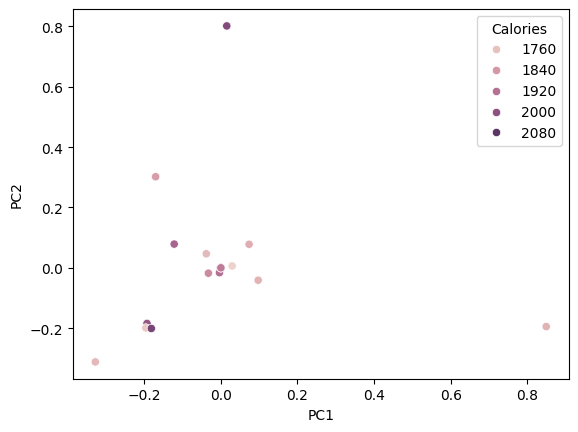

In [51]:
plot_calories_burned = sns.scatterplot(data=pca_calories_burned_df, x='PC1', y='PC2', hue='Calories')

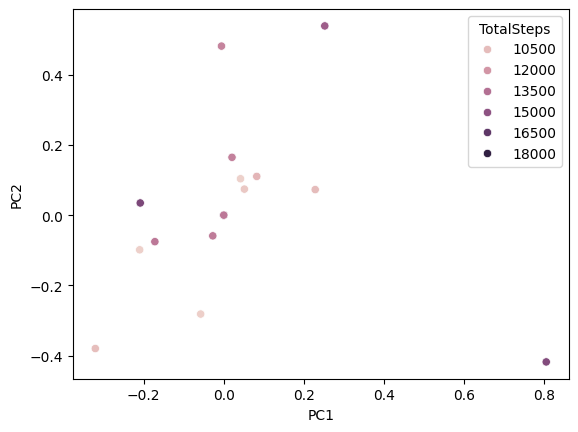

In [52]:
plot_total_steps = sns.scatterplot(data=pca_total_steps_df, x='PC1', y='PC2', hue='TotalSteps')

#### Scree Plot

Text(0, 0.5, 'Explained Variance')

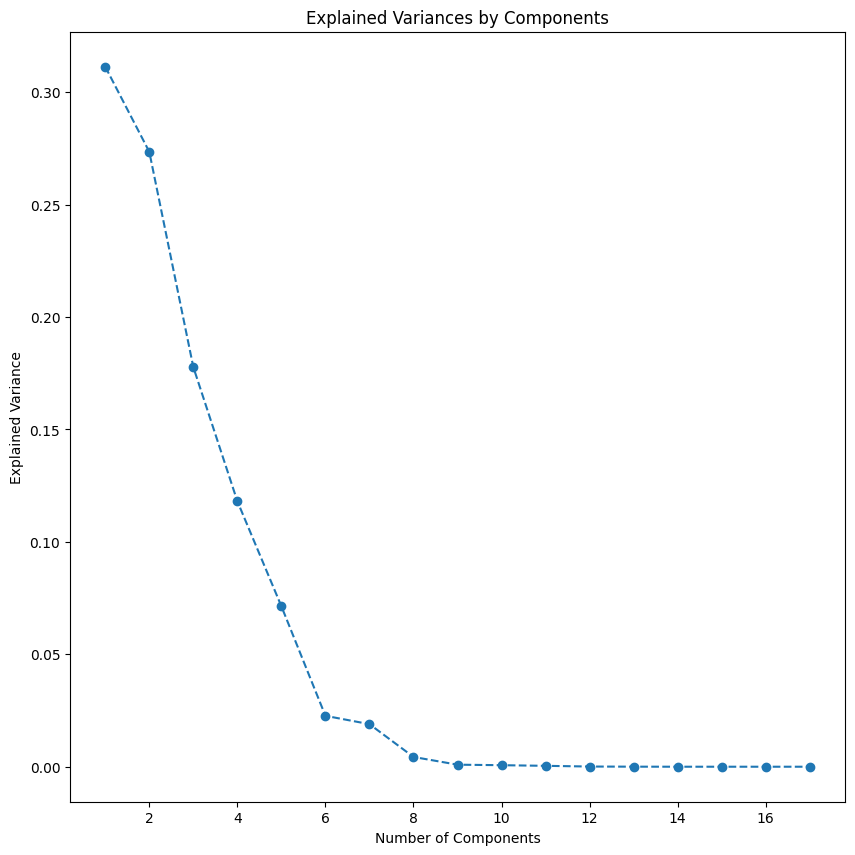

In [53]:
# visualize the Explained Individual Components
plt.figure(figsize = (10,10))
plt.plot(range(1,18), pca_calories_burned.explained_variance_ratio_, marker = 'o', linestyle = '--')
plt.title("Explained Variances by Components")
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance")

Text(0, 0.5, 'Explained Variance')

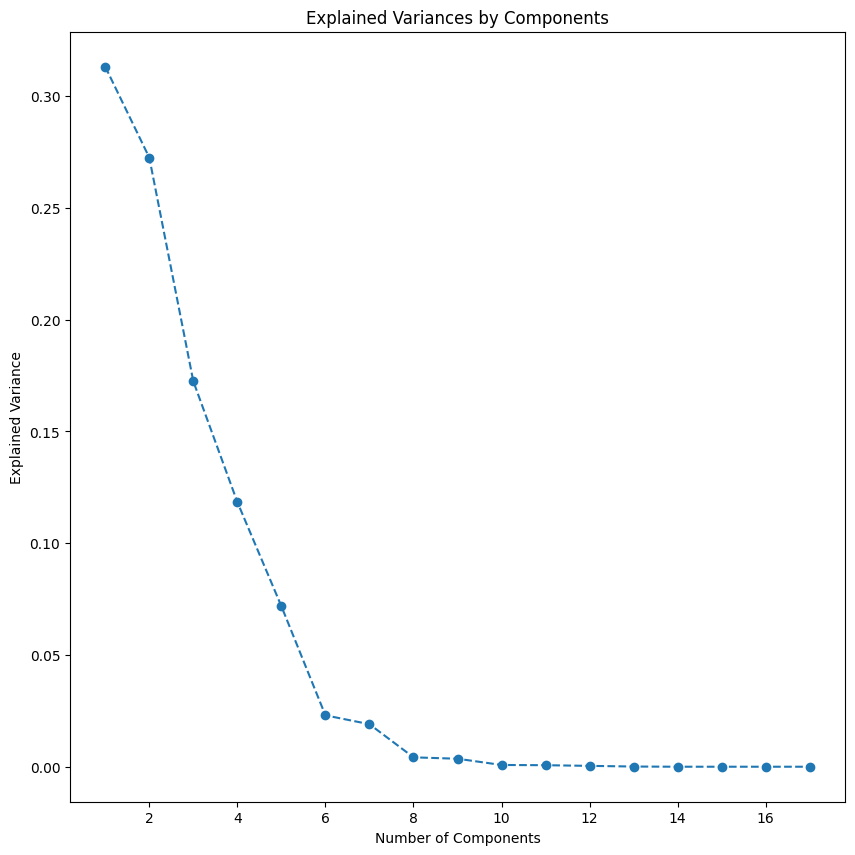

In [54]:
# visualize the Explained Individual Components
plt.figure(figsize = (10,10))
plt.plot(range(1,18), pca_total_steps.explained_variance_ratio_, marker = 'o', linestyle = '--')
plt.title("Explained Variances by Components")
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance")

In [55]:
#The percentage of variance explained by each principal component
explained_variance_calories_burned = pca_calories_burned.explained_variance_ratio_

explained_variance_total_steps = pca_total_steps.explained_variance_ratio_

#### Find the least number of components that can explain more than 70% variance

In [56]:
# find the least number of components that can explain more than 70% variance
sum = 0
for ix, i in enumerate(explained_variance_calories_burned):
  sum = sum + i
  if(sum > 0.7):
    print("Number of PCs that explain at least 70% variance for predicting calories per user: ", ix+1)
    break

Number of PCs that explain at least 70% variance for predicting calories per user:  3


In [57]:
# find the least number of components that can explain more than 70% variance
sum = 0
for ix, i in enumerate(explained_variance_total_steps):
  sum = sum + i
  if(sum > 0.7):
    print("Number of PCs that explain at least 70% variance for predicting total steps per user: ", ix+1)
    break

Number of PCs that explain at least 70% variance for predicting total steps per user:  3


#### Get the index of the most important feature on EACH component using list comprehension

In [58]:
n_pcs_calories_burned= pca_calories_burned.components_.shape[0]

most_important_calories_burned = [np.abs(pca_calories_burned.components_[i]).argmax() for i in range(n_pcs_calories_burned)]

In [59]:
initial_feature_names_calories_burned = X_calories_burned.columns
# get the names
most_important_names_calories_burned = [initial_feature_names_calories_burned[most_important_calories_burned[i]] for i in range(n_pcs_calories_burned)]

In [60]:
dict_intial_feature_names_calories_burned = {'PC{}'.format(i): most_important_names_calories_burned[i] for i in range(n_pcs_calories_burned)}

In [61]:
n_pcs_total_steps= pca_total_steps.components_.shape[0]

most_important_total_steps = [np.abs(pca_total_steps.components_[i]).argmax() for i in range(n_pcs_total_steps)]

In [62]:
initial_feature_names_total_steps = X_total_steps.columns
# get the names
most_important_names_total_steps = [initial_feature_names_total_steps[most_important_total_steps[i]] for i in range(n_pcs_total_steps)]

In [63]:
dict_intial_feature_names_total_steps = {'PC{}'.format(i): most_important_names_total_steps[i] for i in range(n_pcs_total_steps)}

#### Shows the top 5 most influential columns in the dataset per component these columns are what I need to look at adding for my feature data set. Principal Component Analysis uses Singular Value Decomposition of the data to project it to a lower dimensional space

In [64]:
pca_train_data_calories_burned = pd.DataFrame(dict_intial_feature_names_calories_burned.items())

pca_train_data_calories_burned.head(5)

,0,1
0,PC0,WeightKg
1,PC1,TotalTimeInBed
2,PC2,VeryActiveMinutes
3,PC3,FairlyActiveMinutes
4,PC4,VeryActiveDistance


In [65]:
pca_train_data_total_steps = pd.DataFrame(dict_intial_feature_names_total_steps.items())

pca_train_data_total_steps.head(5)

,0,1
0,PC0,SedentaryMinutes
1,PC1,WeightPounds
2,PC2,VeryActiveMinutes
3,PC3,FairlyActiveMinutes
4,PC4,VeryActiveDistance


In [66]:
pca_train_data_calories_burned[1].unique()

array(['WeightKg', 'TotalTimeInBed', 'VeryActiveMinutes',
       'FairlyActiveMinutes', 'VeryActiveDistance', 'TotalSleepRecords',
       'Fat', 'LightlyActiveMinutes', 'SedentaryMinutes',
       'ModeratelyActiveDistance', 'TotalSteps', 'TotalDistance', 'BMI',
       'SedentaryActiveDistance'], dtype=object)

In [67]:
pca_train_data_total_steps[1].unique()

array(['SedentaryMinutes', 'WeightPounds', 'VeryActiveMinutes',
       'FairlyActiveMinutes', 'VeryActiveDistance', 'TotalSleepRecords',
       'Fat', 'LightlyActiveMinutes', 'Calories', 'TotalTimeInBed',
       'TotalDistance', 'WeightKg', 'SedentaryActiveDistance'],
      dtype=object)

#### Data Observations on Principal Component Analysis with TimeSeries Datasets
- the three top columns for calories per user that covers 70% of variance are "BMI", "TotalBedtime", "VeryActiveMinutes"
- the three top columns for total steps per user that covers 70% of variance are "SedentaryMinute", "WeightKg", "VeryActiveMinutes"
- After doing further research, I learned that Principal Component Analysis is not a useful technique for timeseries datasets. The reason why is below.
- Principal Component Analysis (PCA) assumes that the variables are linearly correlated and it ignores the temporal order of the data, which can be problematic for time series data where temporal dependencies exist. Therefore, PCA might not be the best choice for dimensionality reduction in time series data, especially if the temporal dependencies are important for your regression problem. Instead, you might want to consider techniques that take into account the temporal structure of the data, such as autoregressive models, recurrent neural networks (RNNs), or even some form of feature engineering that incorporates the temporal dependencies into the features.
- I'll be using an autoregressive model on the timeseries dataset.

### Data Engineering for model prepration
- Split the datasets into Train, Validation, and Test
    - Split is 70/30 where 70% in the training data and 30% in the Test data
- Convert pandas DataFrames to PyTorch tensors
- Create PyTorch DataLoader for training and validation datasets

In [68]:
X_calories_burned_normalized_0_to_1_tensor = torch.tensor(X_calories_burned_normalized_0_to_1).float() #X_calories_burned_normalized_0_to_1.values
y_calories_burned_tensor = torch.tensor(y_calories_burned_normalized_0_to_1).float()

In [69]:
X_total_steps_normalized_0_to_1_tensor = torch.tensor(X_total_steps_normalized_0_to_1).float() #X_total_steps_normalized_0_to_1.values
y_total_steps_tensor = torch.tensor(y_total_steps_normalized_0_to_1).float()

In [70]:
X_multivariate_per_Id_features_normalized_0_to_1_tensor = torch.tensor(X_multivariate_per_Id_features_normalized_0_to_1).float() #X_multivariate_per_Id_features_normalized_0_to_1.values
y_multivariate_per_Id_target_tensor = torch.tensor(y_multivariate_per_Id_normalized_0_to_1).float()

#### Apply Sliding Window Technique to predict targets for the next 7 days
- The best practice is to apply the train-test split operation before creating the TensorDataset. This is because the train-test split is a form of data preprocessing, and it’s generally best to complete all preprocessing steps before creating the TensorDataset and DataLoader.
- The sliding window technique should be applied after the data has been converted to PyTorch tensors. The reason for this is that the sliding window technique will create sequences of data, and these sequences should be in the form of tensors to be compatible with the PyTorch framework.

In [71]:
def create_sequences_and_split(input_data, output_data, tw, test_size=0.3):
    train_seq = []
    train_label = []
    L = len(input_data)
    for i in range(L-tw-7):  # Subtract 7 to ensure there is enough data to predict the next 7 days
        train_seq.append(input_data[i:i+tw])
        train_label.append(output_data[i+tw:i+tw+7])
    
    # Convert lists to tensors
    train_seq_tensor = torch.stack(train_seq)
    train_label_tensor = torch.stack(train_label)
    
    # Apply train-test split
    X_train, X_val, y_train, y_val = train_test_split(train_seq_tensor, train_label_tensor, test_size=test_size)
    
    # Create TensorDatasets
    train_data = TensorDataset(X_train, y_train)
    val_data = TensorDataset(X_val, y_val)
    
    return train_data, val_data

tw = 7 # Choose your time window

In [72]:
# Apply the sliding window technique through function 'create_sequences_and_split' to the normalized data and create pytorch tensordatasets for train and test
train_data_calories_burned, val_data_calories_burned = create_sequences_and_split(X_calories_burned_normalized_0_to_1_tensor,y_calories_burned_tensor, tw)

In [73]:
# Apply the sliding window technique through function 'create_sequences_and_split' to the normalized data and create pytorch tensordatasets for train and test
train_data_total_steps, val_data_total_steps = create_sequences_and_split(X_total_steps_normalized_0_to_1_tensor,y_total_steps_tensor, tw)

In [74]:
# Apply the sliding window technique through function 'create_sequences_and_split' to the normalized data and create pytorch tensordatasets for train and test
train_data_multivariate_per_Id, val_data_multivariate_per_Id = create_sequences_and_split(X_multivariate_per_Id_features_normalized_0_to_1_tensor,y_multivariate_per_Id_target_tensor, tw)

#### Convert Pandas Dataframes to Pytorch Tensors

In [75]:
batch_size_calories_burned = 32
train_loader_calories_burned = DataLoader(train_data_calories_burned, batch_size=batch_size_calories_burned)
val_loader_calories_burned = DataLoader(val_data_calories_burned, batch_size=batch_size_calories_burned)

In [76]:
batch_size_total_steps = 32
train_loader_total_steps = DataLoader(train_data_total_steps, batch_size=batch_size_total_steps)
val_loader_total_steps = DataLoader(val_data_total_steps, batch_size=batch_size_total_steps)

In [77]:
batch_size_multivariate_per_Id = 32
train_loader_multivariate_per_Id = DataLoader(train_data_multivariate_per_Id, batch_size=batch_size_multivariate_per_Id)
val_loader_multivariate_per_Id = DataLoader(val_data_multivariate_per_Id, batch_size=batch_size_multivariate_per_Id)

### Build Time Series Models using Pytorch
1. Build a Time Series Model to predict the amount of calories per ID (user)
2. Build a Time Series Model to predict the amount of total steps taken per day per ID (user)
3. Build a Time Series Model to predict how many 'Calories', 'TotalDistance', 'TotalMinutesAsleep', 'WeightPounds', 'BMI', 'VeryActiveDistance', 'ModeratelyActiveDistance', 'LightActiveDistance', 'SedentaryActiveDistance', 'VeryActiveMinutes','FairlyActiveMinutes','LightlyActiveMinutes','SedentaryMinutes' per day in the next 7 days for 'Id' ['1927972279'], to get to ten thousand steps per day

##### RNN Model using Dense Activation

In [78]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_prob=0.5):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_size, 7) # Adjust the output dimension to 7

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :]) # Take the last output of the sequence
        return out

#### Time Series Autoregressive Model

In [79]:
class AutoRegressiveModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(AutoRegressiveModel, self).__init__()
        self.lstm1 = nn.LSTM(input_dim, hidden_dim)
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim)  # Add another LSTM layer
        self.linear = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        lstm_out, _ = self.lstm1(x)
        lstm_out, _ = self.lstm2(lstm_out)  # Pass the output of the first LSTM layer to the second LSTM layer
        predictions = self.linear(lstm_out)
        return predictions

#### Set the input and output parameters for the model

In [80]:
input_dim_calories_burned = X_calories_burned_normalized_0_to_1_tensor.shape[1]  # Number of features in the dataset
output_dim_calories_burned = y_calories_burned_tensor.shape[1] # Number of targets in the dataset

input_dim_total_steps = X_total_steps_normalized_0_to_1_tensor.shape[1]  # Number of features in the dataset
output_dim_total_steps = y_total_steps_tensor.shape[1] # Number of targets in the dataset

input_dim_multivariate_per_Id = X_multivariate_per_Id_features_normalized_0_to_1_tensor.shape[1]  # Number of features in the dataset
output_dim_multivariate_per_Id = y_multivariate_per_Id_targets.shape[1] # Number of targets in the dataset

#### Initialize the models and define loss function and optimizer

In [81]:
hidden_dim = 512  # Choose a suitable number for hidden dimensions
criterion = torch.nn.MSELoss()  # Mean Squared Error loss function

In [82]:
model_calories_burned = AutoRegressiveModel(input_dim_calories_burned, hidden_dim, output_dim_calories_burned)
optimizer_calories_burned = Adam(model_calories_burned.parameters(), lr=0.001)  # Learning rate of 0.001

/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [83]:
# I need to be sure the inputs and outputs for this model are correct  
model_total_steps = RNN(input_size=X_total_steps.shape[1], hidden_size=1024, num_layers=3, dropout_prob=0.5)
optimizer_total_steps = Adam(model_total_steps.parameters(), lr=0.001)  # Learning rate of 0.01

In [84]:
model_multivariate_per_Id = AutoRegressiveModel(input_dim_multivariate_per_Id, hidden_dim, output_dim_multivariate_per_Id)
optimizer_multivariate_per_Id = Adam(model_multivariate_per_Id.parameters(), lr=0.001)  # Learning rate of 0.01

### Train the Models
1. Train the Time Series Model to predict the amount of calories per ID (user)
2. Train the Time Series Model to predict the amount of total steps taken per day per ID (user)
3. Train the  Time Series Model to predict how many 'Calories', 'TotalDistance', 'TotalMinutesAsleep', 'WeightPounds', 'BMI', 'VeryActiveDistance', 'ModeratelyActiveDistance', 'LightActiveDistance', 'SedentaryActiveDistance', 'VeryActiveMinutes','FairlyActiveMinutes','LightlyActiveMinutes','SedentaryMinutes' per day in the next 7 days for 'Id' ['1927972279'], to get to ten thousand steps per day

In [85]:
num_epochs = 100 # Number of training iterations
for epoch in range(num_epochs):
    for X, y in train_loader_calories_burned:
        optimizer_calories_burned.zero_grad()
        output = model_calories_burned(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer_calories_burned.step()

In [86]:
num_epochs = 100 # Number of training iterations
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader_total_steps):
        outputs = model_total_steps(inputs)
        outputs = outputs.view(labels.shape[0], labels.shape[1])  # Reshape the output to match the target dimension
        loss = criterion(outputs, outputs.view(labels.shape[0], labels.shape[1]))
        optimizer_total_steps.zero_grad()
        loss.backward()
        optimizer_total_steps.step()

In [87]:
num_epochs = 100 # Number of training iterations
for epoch in range(num_epochs):
    for X, y in train_loader_multivariate_per_Id:
        optimizer_multivariate_per_Id.zero_grad()
        output = model_multivariate_per_Id(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer_multivariate_per_Id.step()

### Evaluate the Models
1. Evaluate the Time Series Model to predict the amount of calories per ID (user)
2. Evaluate the Time Series Model to predict the amount of total steps taken per day per ID (user)
3. Evaluate the Time Series Model to predict how many 'Calories', 'TotalDistance', 'TotalMinutesAsleep', 'WeightPounds', 'BMI', 'VeryActiveDistance', 'ModeratelyActiveDistance', 'LightActiveDistance', 'SedentaryActiveDistance', 'VeryActiveMinutes','FairlyActiveMinutes','LightlyActiveMinutes','SedentaryMinutes' per day in the next 7 days for 'Id' ['1927972279'], to get to ten thousand steps per day

In [88]:
model_calories_burned.eval()
with torch.no_grad():
    val_loss = 0
    for X, y in val_loader_calories_burned:
        output = model_calories_burned(X)
        val_loss += criterion(output, y).item() * len(y)
val_loss /= len(y_calories_burned)
print(f'Validation Loss: {val_loss}')

Validation Loss: 0.006184002040852798


In [89]:
model_total_steps.eval()
with torch.no_grad():
    for i, (inputs, labels) in enumerate(val_loader_total_steps):
        outputs = model_total_steps(inputs)  # Fix: Use the correct model
        # outputs now contains the predicted TotalSteps for the next 7 days
        
        # Rescale the outputs back to their original range
        outputs_rescaled = total_steps_target_scaler.inverse_transform(outputs)

        if i < 10:
            print(f"Record {i+1}:")
            for j in range(7):
                print(f"Day {j+1}: {outputs_rescaled[i][j]}")
            print()


Record 1:
Day 1: -1353.259850166738
Day 2: 659.1636883914471
Day 3: 260.86897747963667
Day 4: -1405.5706715360284
Day 5: 668.5224938187748
Day 6: -960.1359471827745
Day 7: 669.8509550988674

Record 2:
Day 1: -1214.577241141349
Day 2: 680.2620768323541
Day 3: 292.01804332155734
Day 4: -1370.4287412501872
Day 5: 668.0333361402154
Day 6: -1038.431500710547
Day 7: 655.4074860941619

Record 3:
Day 1: -1256.025957658887
Day 2: 596.9602215662599
Day 3: 299.28258163668215
Day 4: -1436.7856539078057
Day 5: 657.4142334982753
Day 6: -1176.155384838581
Day 7: 603.209041506052

Record 4:
Day 1: -1236.8357605077326
Day 2: 638.3053501732647
Day 3: 275.2189221661538
Day 4: -1278.531638853252
Day 5: 716.310870969668
Day 6: -1072.8343607746065
Day 7: 645.598838089034

Record 5:
Day 1: -1587.9312840551138
Day 2: 369.06829438731074
Day 3: 305.3217434026301
Day 4: -1508.6158189885318
Day 5: 421.1840162463486
Day 6: -839.0047799311578
Day 7: 322.53900681994855

Record 6:
Day 1: -1228.5079365707934
Day 2: 67

In [90]:
model_multivariate_per_Id.eval()
with torch.no_grad():
    val_loss = 0
    for X, y in val_loader_multivariate_per_Id:
        output = model_multivariate_per_Id(X)
        val_loss += criterion(output, y).item() * len(y)
val_loss /= len(y_multivariate_per_Id_targets)
print(f'Validation Loss: {val_loss}')

Validation Loss: 0.00797932090297822


### Make Predictions with the Models
1. Predicting the next 7 days' calories burned for each Id
2. Predicting the next 7 days' total steps for each Id
3. Predict how many 'Calories', 'TotalDistance', 'TotalMinutesAsleep', 'WeightPounds', 'BMI', 'VeryActiveDistance', 'ModeratelyActiveDistance', 'LightActiveDistance', 'SedentaryActiveDistance', 'VeryActiveMinutes','FairlyActiveMinutes','LightlyActiveMinutes', and 'SedentaryMinutes' per day in the next 7 days for 'Id' ['1927972279'], to get to a total of ten thousand steps per day.

In [91]:
predictions = []
for id in X_calories_burned.index:
    x = torch.tensor(X_calories_burned.loc[id].values).float().unsqueeze(0)  # Input for one Id
    prediction = model_calories_burned(x)[-1, 0]  # Last time step's output is the prediction
    predictions.append(prediction.item())

In [92]:
predictions = np.array(predictions).reshape(-1, 1)
predictions = predictions[:len(y_calories_burned)]  # Ensure predictions has the same length as y_calories_burned

# Assume calories_burned_scaler is the MinMaxScaler fitted to the targets
predictions_rescaled = calories_burned_targets_scaler.inverse_transform(predictions)
#print(predictions)

# Create a DataFrame with index values, actual values, and predicted values
df_predictions_calories = pd.DataFrame({
    'Id_DateMerge_Index': y_calories_burned.index,
    'Actual': y_calories_burned.values.flatten(),
    'Predicted': predictions_rescaled.flatten()
})

# Set index to 'Id_DateMerge_Index'
df_predictions_calories.set_index('Id_DateMerge_Index', inplace=True)

# Print the DataFrame
print(df_predictions_calories.head(10))

                                   Actual    Predicted
Id_DateMerge_Index                                    
(1503960366, 2016-04-12 00:00:00)  1985.0 -3900.086635
(1503960366, 2016-04-13 00:00:00)  1797.0 -4003.768039
(1503960366, 2016-04-14 00:00:00)  1776.0 -4276.456523
(1503960366, 2016-04-15 00:00:00)  1745.0 -4018.833220
(1503960366, 2016-04-16 00:00:00)  1863.0 -3883.358741
(1503960366, 2016-04-17 00:00:00)  1728.0 -4040.396798
(1503960366, 2016-04-18 00:00:00)  1921.0 -4141.185319
(1503960366, 2016-04-19 00:00:00)  2035.0 -3888.670194
(1503960366, 2016-04-20 00:00:00)  1786.0 -3973.067278
(1503960366, 2016-04-21 00:00:00)  1775.0 -3976.751941


In [93]:
predictions = []
for id in X_total_steps.index:
    x = torch.tensor(X_total_steps.loc[id].values).float().unsqueeze(0)  # Input for one Id
    x = x.view(x.size(0), x.size(1), -1)  # Reshape the input tensor to match the expected input size
    prediction = model_total_steps(x)  # Last time step's output is the prediction
    prediction_rescaled = total_steps_target_scaler.inverse_transform(prediction.detach().numpy())
    predictions.append(prediction_rescaled)

In [94]:
# Sort the predictions in descending order and take the top 10
top_ten_predictions = sorted(np.array(predictions).flatten(), reverse=True)[:10]

# Print the top 10 predictions in descending order for analysis purposes
for i, pred in enumerate(top_ten_predictions, start=1):
    if np.any(pred):
        print(f"Prediction {i}: {pred}")


Prediction 1: 19841.44140625
Prediction 2: 19841.0703125
Prediction 3: 19805.650390625
Prediction 4: 19790.2109375
Prediction 5: 19615.525390625
Prediction 6: 19614.189453125
Prediction 7: 19609.8359375
Prediction 8: 19528.658203125
Prediction 9: 19375.705078125
Prediction 10: 19277.1953125


In [95]:

# Ensure that the arrays have the same length
min_length = min(len(y_total_steps.index), len(y_total_steps.values.flatten()), len(predictions))
y_total_steps = y_total_steps[:min_length]
predictions = np.array(predictions).flatten()[:min_length]

# Create a DataFrame with index values, actual values, and predicted values
df_predictions_total_steps = pd.DataFrame({
    'Id_DateMerge_Index': y_total_steps.index,
    'Actual': y_total_steps.values.flatten(),
    'Predicted': predictions.flatten()
})

# Set index to 'Id_DateMerge_Index'
df_predictions_total_steps.set_index('Id_DateMerge_Index', inplace=True)

In [96]:
df_predictions_total_steps.head(10)

,Actual,Predicted
Id_DateMerge_Index,,
"(1503960366, 2016-04-12 00:00:00)",13162.0,-2465.815674
"(1503960366, 2016-04-13 00:00:00)",10735.0,3340.379395
"(1503960366, 2016-04-14 00:00:00)",10460.0,7214.879395
"(1503960366, 2016-04-15 00:00:00)",9762.0,363.752960
"(1503960366, 2016-04-16 00:00:00)",12669.0,12057.189453
"(1503960366, 2016-04-17 00:00:00)",9705.0,1260.341797
"(1503960366, 2016-04-18 00:00:00)",13019.0,7811.372070
"(1503960366, 2016-04-19 00:00:00)",15506.0,-3233.113525
"(1503960366, 2016-04-20 00:00:00)",10544.0,3485.550781


In [97]:
predictions = []
for id in X_multivariate_per_Id_features.index:
    x = torch.tensor(X_multivariate_per_Id_features.loc[id].values).float().unsqueeze(0)  # Input for one Id
    prediction = model_multivariate_per_Id(x)  # Last time step's output is the prediction
    predictions_rescaled = multivariate_target_scaler.inverse_transform(prediction.detach().numpy())
    predictions.append(predictions_rescaled.flatten())

In [98]:
# Ensure that the arrays have the same length
min_length = min(len(y_multivariate_per_Id_targets.index), len(y_multivariate_per_Id_targets.values.flatten()), len(predictions_rescaled.flatten()))
y_multivariate_per_Id_targets = y_multivariate_per_Id_targets[:min_length]
predictions = predictions[:min_length]


Add predictions to dataframe and output the dataframe results to a CSV file called 'merged_data_and_predictions'

In [99]:
# Create a copy of 'merged_df'
merged_data_and_predictions = merged_df.copy()

In [100]:
# Name the index column 'Id_DateMerge_Index'
merged_data_and_predictions.index.name = 'Id_DateMerge_Index'

In [101]:
# Reset the index column on merged_data_and_predictions and drop the index columns on df_predictions_calories and df_predictions_total_steps and join on the column name 'Id_DateMerge_Index' for both dataframes
merged_data_and_predictions = merged_data_and_predictions.reset_index(drop=False)
df_predictions_calories = df_predictions_calories.reset_index(drop=True)
df_predictions_total_steps = df_predictions_total_steps.reset_index(drop=True)

In [102]:
# Merge the dataframes
merged_data_and_predictions = merged_data_and_predictions.merge(df_predictions_calories[['Predicted']], left_index=True, right_index=True)
merged_data_and_predictions.rename(columns={'Predicted': 'predicted_calories'}, inplace=True)

merged_data_and_predictions = merged_data_and_predictions.merge(df_predictions_total_steps[['Predicted']], left_index=True, right_index=True)
merged_data_and_predictions.rename(columns={'Predicted': 'predicted_total_steps'}, inplace=True)

In [103]:
# Assuming that 'predictions' is a 2D array where each row corresponds to a prediction
# and each column corresponds to a target

# Convert predictions to a DataFrame
df_predictions_multivariate = pd.DataFrame(predictions, columns=targets)

# Add 'Id' and 'Date_Merge' column to df_predictions_multivariate
df_predictions_multivariate['Id_DateMerge_Index'] = y_multivariate_per_Id_targets.index


# Add predicted columns to 'merged_data_and_predictions'
for target in targets:
    merged_data_and_predictions['predicted_multivariate' + target] = df_predictions_multivariate[target]

In [104]:
# Set index on merged_data_and_predictions on the column 'Id' and 'Date_Merge'
merged_data_and_predictions.set_index(['Id', 'Date_Merge'], inplace=True)

# Name the index column on merged_data_and_predictions as 'Id_DateMerge_Index'
merged_data_and_predictions.index.name = 'Id_DateMerge_Index'

In [105]:
# Merge 'merged_data_and_predictions' back to 'merged_df'
merged_df = pd.concat([merged_df, merged_data_and_predictions], axis=1)

# Output results from merged dataframe merged_df to a csv file called 'merged_df.csv'
merged_data_and_predictions.to_csv('merged_data_and_predictions.csv')